### Анализ устойчивости

За время $t = 20000.0$  
Граница при явном методе $\tau = 0.45, h = 0.001$ равна $0.15982$    
Граница при неявном методе $\tau = 0.45, h = 0.001$ равна $0.15957$  
Граница при методе Кранка-Никольсона $\tau = 0.45, h = 0.001$ равна $0.15969$

Максимальная разница явного и неявного $0.027$ или $0.01\%$  
Максимальная разница явного и Кранка $0.011$ или $0.004\%$  
Максимальная разница неявного и Кранка $0.016$ или $0.006\%$

Явный метод

За время $t = 200000.0$  
Граница при $\tau = 0.45, h = 0.001$ равна $0.4568$   
Граница при $\tau = 0.45/4, h = 0.001/2$ равна $0.4563$

Максимальная абсолютная разница $0.024$  
Максимальная относительная разница $0.01 \%$

Неявный метод

За время $t = 20000.0$  
Граница при $\tau = 0.45, h = 0.001$ равна $0.15957$   
Граница при $\tau = 50.0, h = 0.001$ равна $0.1633$

Максимальная абсолютная разница $0.2407$  
Максимальная относительная разница $0.1\%$

Метод Кранка-Никольсона

За время $t = 20000.0$  
Граница при $\tau = 0.45, h = 0.001$ равна $0.15957$   
Граница при $\tau = 1.0, h = 0.001$ равна $0.1598$

Максимальная абсолютная разница $0.0292$  
Максимальная относительная разница $0.005\%$

In [6]:
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib

### Defining constants

In [196]:
l = 1.0
rho = 1000.0 
c_f = 4200.0
c_s = 2100.0
a_f = 0.56
a_s = 2.25
L = 33000.0

### Thomas algorithm

In [197]:
def TDMAsolver(a, b, c, d):
    nf = len(d) # number of equations
    if nf == 1:
        return  d / b
    
    for it in range(1, nf):
        m = a[it-1] / b[it-1]
        b[it] -= m*c[it-1] 
        d[it] -= m*d[it-1]

    x = b
    x[-1] = d[-1]/b[-1]

    for il in range(nf-2, -1, -1):
        x[il] = (d[il]-c[il]*x[il+1])/b[il]
    
    return x

In [419]:
class StefanProblemSolve:
    def __init__(self, tau, h, step_type):
        self.tau = tau
        self.h = h
        
        self.r_s = a_s * tau / h / h / rho / c_s
        self.r_f = a_f * tau / h / h / rho / c_f
        self.r_b = tau / rho / L / h
        self.step_type = step_type
        
        self.N = math.ceil(1 / h) + 1
        self.u = np.zeros(self.N, dtype=np.float128)

        self.u = g(np.arange(-2, self.N-2) / (self.N - 3))

        self.u[0] = self.f1(0)
        self.u[1] = (u[2] + u[0]) / 2 
        self.u[-1] = self.f2(0)

        self.y = 2 * h
        self.bo = int(round(self.y / self.h))
        self.t = 0.0

        self.next_0 = self.f1(self.t)
        self.next_1 = self.f2(self.t)
        
    def f1(self, t):
        return 273.0 - 13 * (1 - np.exp(-np.power(10, 4 * t)))
        
    def f2(self, t):
        return 280.0
    
    def g(self, x):
        return 7 * x / l + 273.0
     
    def step(self):
        if self.step_type == "explicit":
            dif_s = np.around(self.r_s*(self.u[2:self.bo+1] - 2 * self.u[1:self.bo] + \
                                        self.u[:self.bo-1]), decimals=10)
            dif_f = np.around(self.r_f*(self.u[self.bo+2:] - 2 * self.u[self.bo+1:-1] + \
                                        self.u[self.bo:-2]), decimals=10)

            self.u[1:self.bo] += dif_s
            self.u[self.bo+1:-1] += dif_f
            return
    
        if self.step_type == "implicit":
            b_f = np.array([1 / self.r_f + 2] * (self.N - self.bo - 2))
            a_f = np.array([-1] * (self.N - self.bo - 3))
        
            b_s = np.array([1 / self.r_s + 2] * (self.bo - 1))
            a_s = np.array([-1] * (self.bo - 2))
            
            test_f = self.u[self.bo+1:-1] / self.r_f
            test_s = self.u[1:self.bo] / self.r_s
        
        elif self.step_type == "crank":
            b_f = np.array([2 / self.r_f + 2] * (self.N-self.bo-2))
            a_f = np.array([-1] * (self.N - self.bo - 3))

            test_f = (2/self.r_f - 2) * self.u[self.bo+1:-1] + self.u[self.bo:-2] + self.u[self.bo+2:]

            b_s = np.array([2 / self.r_s + 2] * (self.bo - 1))
            a_s = np.array([-1] * (self.bo - 2))

            test_s = (2/self.r_s - 2) * self.u[1:self.bo] + self.u[:self.bo-1] + self.u[2:self.bo+1]
        
        test_f[-1] += self.next_1
        test_f[0] += 273.0
        
        test_s[0] += self.next_0
        test_s[-1]+= 273.0

        self.u[1:self.bo] = TDMAsolver(a_s, b_s, a_s, test_s)
        self.u[self.bo+1:-1] = TDMAsolver(a_f, b_f, a_f, test_f)
        
    def border_step(self):
        dif = np.around(self.r_b * (a_s * (self.u[self.bo] - self.u[self.bo-1]) - \
                                    a_f * (self.u[self.bo+1] - self.u[self.bo])), decimals=14)
        self.y += dif
    
    def calculate(self):
        self.u[0] = self.next_0
        self.u[-1] = self.next_1

        self.next_0 = self.f1(self.t+self.tau)
        self.next_1 = self.f2(self.t+self.tau)

        self.border_step()
        self.bo = int(np.round(self.y / self.h))
        self.u[self.bo] = 273.0
        
        self.step()
        self.t += self.tau
        
        return self.u, self.y

### Initialization

In [486]:
tau = 1.0
h = 0.001
borders = []
arrays = np.copy(u)
k = 0

### Explicit method

 $u_{j}^{n+1} = (1-2r)u_{j}^{n} + ru_{j-1}^{n} + ru_{j+1}^{n}$  

In [342]:
solve_e = StefanProblemSolve(tau, h, "explicit")

In [347]:
while solve_e.t < 2000000.0:
    tmp_u, tmp_y = solve_e.calculate()
    if int(np.round(solve_e.t / tau)) % 200 == 0:
        k += 1
        borders.append(tmp_y)
        arrays = np.vstack((arrays, tmp_u))

/home/anvilarth/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power


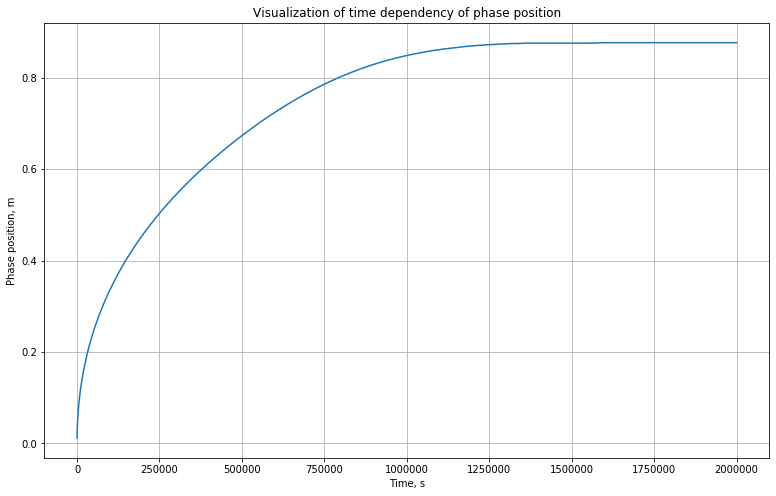

In [355]:
plt.figure(figsize = (13, 8))
plt.plot(np.arange(k) * 200 * tau, borders)
plt.title("Visualization of time dependency of phase position")
plt.xlabel("Time, s")
plt.ylabel("Phase position, m")
plt.grid()
plt.savefig("phase.png")
plt.show()

Предельная координата фронта $0.8765$ за время $1620000.0$

### Implicit method

  $(1+2r)u_j^{n+1} - ru_{j-1}^{n+1} - ru_{j+1}^{n+1}= u_{j}^{n}$  

In [203]:
solve_i = StefanProblemSolve(tau, h, "implicit")
while solve_i.t < 100.0:
    solve_i.calculate()

/home/anvilarth/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power


### Crank–Nicolson method

$(2+2r)u_j^{n+1} - ru_{j-1}^{n+1} - ru_{j+1}^{n+1}= (2-2r)u_j^n + ru_{j-1}^n + ru_{j+1}^n $

In [204]:
solve_c = StefanProblemSolve(tau, h, "crank")
while solve_c.t < 100.0:
    solve_c.calculate()

/home/anvilarth/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power


### Animation

In [16]:
arrays = np.load("arrays.npy")
N = arrays.shape[1]
tau = 0.45

<IPython.core.display.Javascript object>


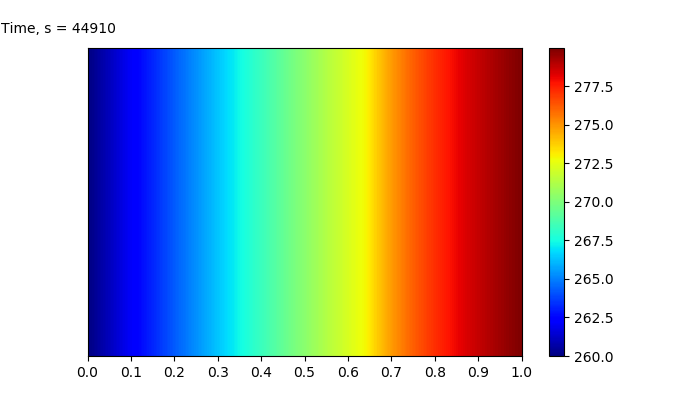

In [44]:
%matplotlib notebook
c = np.repeat(arrays[0, None, :], 2, axis=0)

#  Длинна x и y совпадает с длиной
#  и шириной c:
x = np.arange(N) / N
y = [0, 1]

fig = plt.figure(figsize = (7, 4))
pcm = plt.pcolormesh(x, y, c, cmap=plt.cm.jet)

time_text = plt.text(-0.2, 1.05, '')
plt.xticks(np.arange(0,1.01, 0.1))
plt.yticks([])
plt.colorbar()

def step(i):
    if i >= 500: return
    for_vis = np.repeat(arrays[10 * i, None, :], 2, axis = 0)
    pcm.set_array(for_vis.ravel())
    plt.draw()
    time_text.set_text(f'Time, s = {round(i*0.45*200)}' )
    return pcm, time_text

anim = FuncAnimation(fig, step, interval=2, blit=True, repeat=False, save_count=500)
plt.show()

<IPython.core.display.Javascript object>


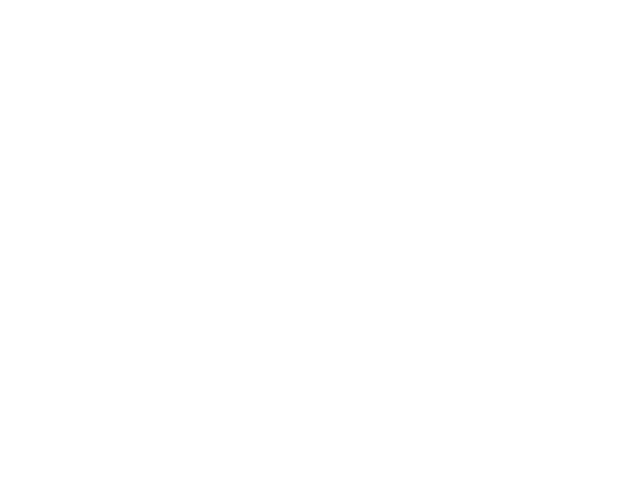

In [46]:
anim.save("stephan.gif", writer="pillow", fps = 1000)